In [26]:
import os

# Limit the number of threads for various libraries
os.environ["MKL_NUM_THREADS"] = "12"  # For MKL (used by NumPy)
os.environ["NUMEXPR_NUM_THREADS"] = "12"  # For NumExpr
os.environ["VECLIB_MAXIMUM_THREADS"] = "12"  # For macOS Accelerate
os.environ["OPENBLAS_NUM_THREADS"] = "12"  # For OpenBLAS
os.environ["BLIS_NUM_THREADS"] = "12"  # For BLIS

# Print environment variables to verify
print("OMP_NUM_THREADS:", os.environ.get("OMP_NUM_THREADS"))
print("MKL_NUM_THREADS:", os.environ.get("MKL_NUM_THREADS"))
print("NUMEXPR_NUM_THREADS:", os.environ.get("NUMEXPR_NUM_THREADS"))
print("VECLIB_MAXIMUM_THREADS:", os.environ.get("VECLIB_MAXIMUM_THREADS"))
print("OPENBLAS_NUM_THREADS:", os.environ.get("OPENBLAS_NUM_THREADS"))
print("BLIS_NUM_THREADS:", os.environ.get("BLIS_NUM_THREADS"))

# Set PyTorch threads
import torch
torch.set_num_threads(18)
torch.set_num_interop_threads(18)

OMP_NUM_THREADS: None
MKL_NUM_THREADS: 12
NUMEXPR_NUM_THREADS: 12
VECLIB_MAXIMUM_THREADS: 12
OPENBLAS_NUM_THREADS: 12
BLIS_NUM_THREADS: 12


RuntimeError: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called

In [2]:
%cd ../..

/data/users/rodalex/RepClassifier


In [3]:
# WrappedRepresentationDataset & PCAExplainability - Usage Demo
# ======================================================
# This notebook demonstrates how to use WrappedRepresentationDataset and PCAExplainability
# to perform dimensionality reduction and interpret protein embedding data.

from project_root.dataset.dataset_loader import DatasetLoader
from project_root.dataset.representation_dataset import RepresentationDataset
from project_root.dataset.wrapped_representation_dataset import WrappedRepresentationDataset
from project_root.utils.visualization import DataVisualizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ------------------------------------------------------
# 📥 1. Load Dataset and Embeddings
# ------------------------------------------------------

# Define data path
path_dataset_folder = "../DATASETS/"

# Load data
loader = DatasetLoader(path_dataset_folder)
df = loader.load_dataframe()
embeddings, attention_weights = loader.load_embeddings_and_attention()

# Create RepresentationDataset instance
representation_dataset = RepresentationDataset(df, embeddings, attention_weights, solve_inconsistencies=True)

Checking consistency...
Removing duplicate entries...
Resolving inconsistencies. Keeping 1219 common samples.
Consistency checked.

ProteinDataset Report:
 - Number of samples: 1219
 - Number of embeddings: 1219
 - Number of attention weights: 1219
 - Target column: Class
 - ID column: UniProt IDs
 - Save path: ./OUTPUTS/
 - Min sequence length: 44
 - Max sequence length: 2499
 - Mean sequence length: 491.42



In [4]:
# Check atributtes
print("Dataset attributes:")
print(representation_dataset.dataframe.columns)
print(representation_dataset.dataframe.head())

Dataset attributes:
Index(['UniProt IDs', 'PDB ID', 'Gene Name', 'Protein Name',
       'Amino Acid Sequence', 'Organism Name', 'Status', 'Protein Existence',
       'GO BP Terms', 'GO CC Terms', 'GO MF Terms', 'Max_MBL_CC',
       'CC_Pairs_Max_MBL', 'Max_MBL_MF', 'MF_Pairs_Max_MBL', 'Highest_MBL',
       'Class'],
      dtype='object')
  UniProt IDs                                             PDB ID  \
1      Q9Y2X8                                                NaN   
2      Q05086  1C4Z; 1D5F; 1EQX; 2KR1; 4GIZ; 4XR8; 6SJV; 6SLM...   
3      Q9Y6X0                                                NaN   
4      Q8BH75                                               2OGB   
5      Q04120                                   5DVB; 5EPT; 6UTL   

                                           Gene Name  \
1         {'Name': 'UBE2D4', 'Synonyms': ['UBCH5D']}   
2  {'Name': 'UBE3A {ECO:0000312|HGNC:HGNC:12496}'...   
3       {'Name': 'SETBP1', 'Synonyms': ['KIAA0437']}   
4   {'Name': 'Rnf41', 'Syno

In [5]:
# Print number of protins with Protein Existence diferent from 1
print("Number of proteins with Protein Existence different from 1:", len(representation_dataset.dataframe[representation_dataset.dataframe["Protein Existence"] != 1.]))

# Print unic values of GO BP Terms, GO CC Terms, GO MF Terms
print("Number of unique values of GO BP Terms:")
print(len(representation_dataset.dataframe["GO BP Terms"].unique()))
print("Number of unique values of GO CC Terms:")
print(len(representation_dataset.dataframe["GO CC Terms"].unique()))
print("Number of unique values of GO MF Terms:")
print(len(representation_dataset.dataframe["GO MF Terms"].unique()))


Number of proteins with Protein Existence different from 1: 31
Number of unique values of GO BP Terms:
1171
Number of unique values of GO CC Terms:
1012
Number of unique values of GO MF Terms:
1088


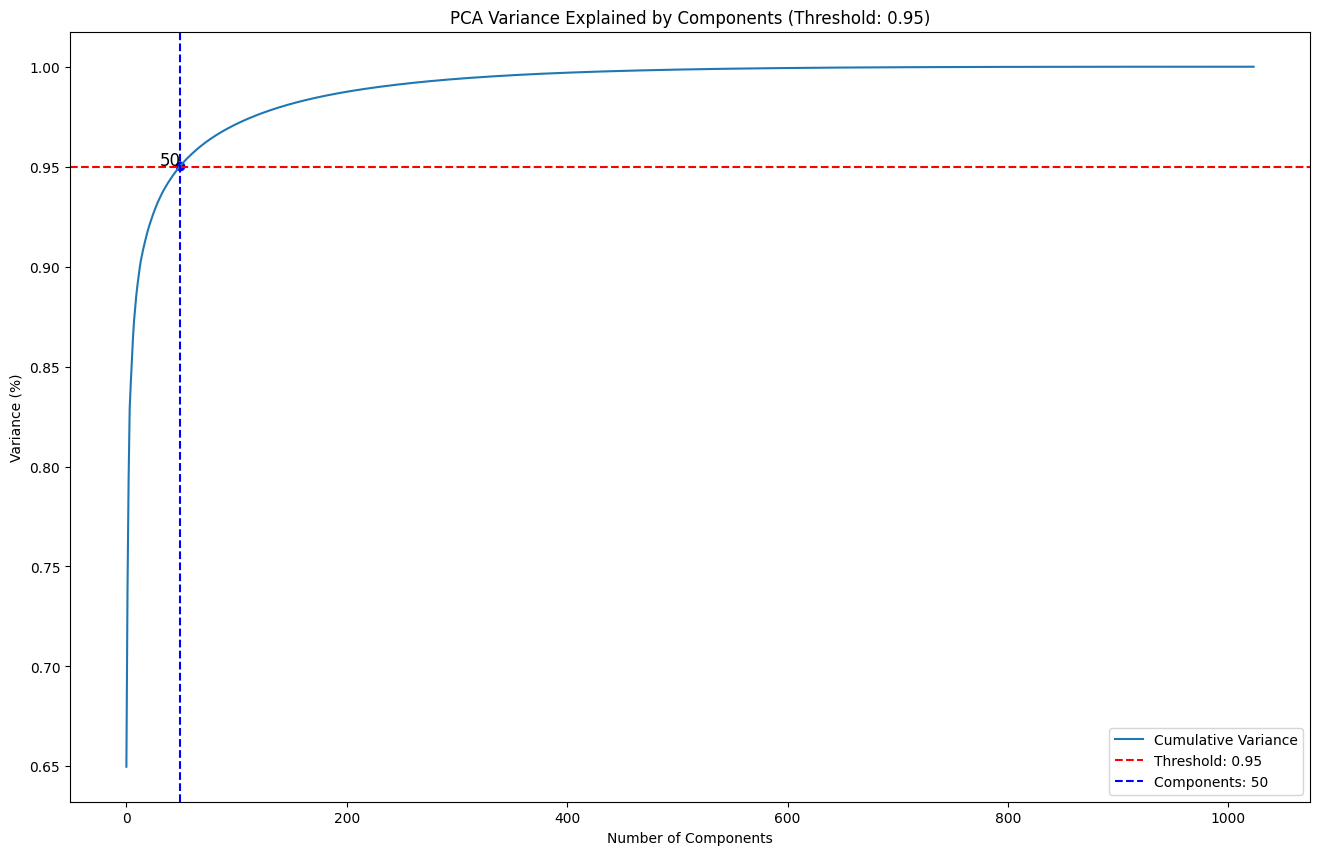

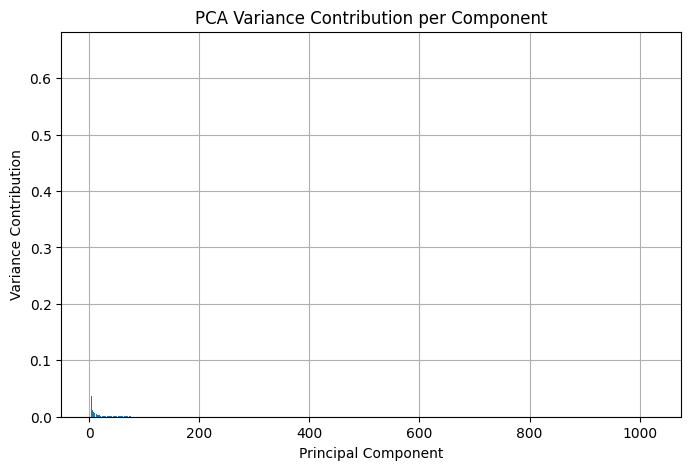

In [4]:
from sklearn.decomposition import PCA

# Apply PCA to the embeddings
original_embeddings = representation_dataset.get_embeddings()

# Create the PCA object
n_components = min(len(original_embeddings), len(original_embeddings[0]))
pca = PCA(n_components=n_components)

# Fit the PCA object and transform the data
original_embeddings_pca = pca.fit_transform(original_embeddings)

# Data Visualizer
DataVisualizer.plot_variance_explained(pca)  # Pass the PCA object
DataVisualizer.plot_variance_contribution(pca)  # Pass the PCA object

In [12]:
def normalize_data(data):
    """Normalize the data using StandardScaler."""
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def train_model(data, seed=2025):
    # Set random seed for reproducibility
    np.random.seed(seed)

    # -----------------------------------------
    # 🧪 Normalize and split data
    # -----------------------------------------
    X = normalize_data(data)
    y = np.array(representation_dataset.get_labels())

    # Split the data into train and test sets (60% train, 40% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # -----------------------------------------
    # 🌲 Train Random Forest model
    # -----------------------------------------
    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    model.fit(X_train, y_train)

    # -----------------------------------------
    # 📈 Evaluate the model
    # -----------------------------------------
    y_pred = model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("✅ Random Forest training complete")

    return model, X_train, X_test, y_train, y_test

In [ ]:
# ------------------------------------------------------
# 🧪 2. Create WrappedRepresentationDataset with Configurations
# ------------------------------------------------------

wrapped_dataset = WrappedRepresentationDataset(
    dataset=representation_dataset,
    process_attention_weights=True,
    reduce_method='pca',              # or 'tsne'
    pca_method='threshold',           # 'threshold', 'derivative', 'custom'
    threshold=0.95,
    random_projection_dim=50        # Random projection dim before PCA on attention weights
)

Converting embeddings and attention weights to NumPy arrays...


In [21]:
data_emb = wrapped_dataset.select_data(embedding = True,
                                   attention_weights = False)

data_emb_mbl = wrapped_dataset.select_data(embedding = True,
                                      attention_weights = False,
                                      additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                      )

data_att = wrapped_dataset.select_data(embedding = False,
                                      attention_weights = True)

data_att_mbl = wrapped_dataset.select_data(embedding = False,
                                      attention_weights = True,
                                      additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                      )

data_comb = wrapped_dataset.select_data(embedding = True, 
                                   attention_weights = True)

data_comb_mbl = wrapped_dataset.select_data(embedding = True, 
                                   attention_weights = True, 
                                   additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                   )

# The mbl corresponds with the first 3 columns of the additional columns
data_mbl = data_emb_mbl[:, :3]

Final data shape: (1219, 50)
Column order in the resulting dataset:
Adding additional columns to data...
Shape data before adding: (1219, 50) | Shape column: (1219, 1)
Shape data before adding: (1219, 51) | Shape column: (1219, 1)
Shape data before adding: (1219, 52) | Shape column: (1219, 1)
Final data shape: (1219, 53)
Column order in the resulting dataset:
Column 0: Max_MBL_CC
Column 1: Max_MBL_MF
Column 2: Highest_MBL
Final data shape: (1219, 46)
Column order in the resulting dataset:
Adding additional columns to data...
Shape data before adding: (1219, 46) | Shape column: (1219, 1)
Shape data before adding: (1219, 47) | Shape column: (1219, 1)
Shape data before adding: (1219, 48) | Shape column: (1219, 1)
Final data shape: (1219, 49)
Column order in the resulting dataset:
Column 0: Max_MBL_CC
Column 1: Max_MBL_MF
Column 2: Highest_MBL
Final data shape: (1219, 96)
Column order in the resulting dataset:
Adding additional columns to data...
Shape data before adding: (1219, 96) | Shap

In [23]:
print("MBL atributes Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_mbl)
print('-'*50)
print('-'*50)
print("Embeddings MBL Random Forest:")
_, _, _, _, _ = train_model(data_emb_mbl)
print('-'*50)
print('-'*50)
print("Attention Weights MBL Random Forest:")
_, _, _, _, _ = train_model(data_att_mbl)
print('-'*50)
print('-'*50)
print("Combined MBL Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_comb_mbl)
print('-'*50)

print("Embeddings Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_emb)
print('-'*50)
print('-'*50)
print("Attention Weights Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_att)
print('-'*50)
print('-'*50)
print("Combined Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_comb)
print('-'*50)
print('-'*50)

MBL atributes Random Forest:
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95       268
        True       0.98      0.88      0.93       220

    accuracy                           0.94       488
   macro avg       0.95      0.94      0.94       488
weighted avg       0.94      0.94      0.94       488

Confusion Matrix:
[[265   3]
 [ 26 194]]
✅ Random Forest training complete
--------------------------------------------------
--------------------------------------------------
Embeddings MBL Random Forest:
Classification Report:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95       268
        True       0.99      0.88      0.93       220

    accuracy                           0.94       488
   macro avg       0.95      0.94      0.94       488
weighted avg       0.95      0.94      0.94       488

Confusion Mat

In [27]:
# ------------------------------------------------------
# 🧪 2. Create WrappedRepresentationDataset with Configurations
# ------------------------------------------------------

wrapped_dataset_98 = WrappedRepresentationDataset(
    dataset=representation_dataset,
    process_attention_weights=True,
    reduce_method='pca',              # or 'tsne'
    pca_method='threshold',           # 'threshold', 'derivative', 'custom'
    threshold=0.98,
    random_projection_dim=50        # Random projection dim before PCA on attention weights
)

Converting embeddings and attention weights to NumPy arrays...
Applying random projection to reduce attention weights from 6255001 to 50 dimensions...
Applying dimensionality reduction using pca...


In [28]:
data_emb = wrapped_dataset_98.select_data(embedding = True,
                                   attention_weights = False)

data_emb_mbl = wrapped_dataset_98.select_data(embedding = True,
                                      attention_weights = False,
                                      additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                      )

data_att = wrapped_dataset_98.select_data(embedding = False,
                                      attention_weights = True)

data_att_mbl = wrapped_dataset_98.select_data(embedding = False,
                                      attention_weights = True,
                                      additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                      )

data_comb = wrapped_dataset_98.select_data(embedding = True, 
                                   attention_weights = True)

data_comb_mbl = wrapped_dataset_98.select_data(embedding = True, 
                                   attention_weights = True, 
                                   additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                   )

# The mbl corresponds with the first 3 columns of the additional columns
data_mbl = data_emb_mbl[:, :3]

Final data shape: (1219, 142)
Column order in the resulting dataset:
Adding additional columns to data...
Shape data before adding: (1219, 142) | Shape column: (1219, 1)
Shape data before adding: (1219, 143) | Shape column: (1219, 1)
Shape data before adding: (1219, 144) | Shape column: (1219, 1)
Final data shape: (1219, 145)
Column order in the resulting dataset:
Column 0: Max_MBL_CC
Column 1: Max_MBL_MF
Column 2: Highest_MBL
Final data shape: (1219, 49)
Column order in the resulting dataset:
Adding additional columns to data...
Shape data before adding: (1219, 49) | Shape column: (1219, 1)
Shape data before adding: (1219, 50) | Shape column: (1219, 1)
Shape data before adding: (1219, 51) | Shape column: (1219, 1)
Final data shape: (1219, 52)
Column order in the resulting dataset:
Column 0: Max_MBL_CC
Column 1: Max_MBL_MF
Column 2: Highest_MBL
Final data shape: (1219, 191)
Column order in the resulting dataset:
Adding additional columns to data...
Shape data before adding: (1219, 191)

In [29]:
print("MBL atributes Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_mbl)
print('-'*50)
print('-'*50)
print("Embeddings MBL Random Forest:")
_, _, _, _, _ = train_model(data_emb_mbl)
print('-'*50)
print('-'*50)
print("Attention Weights MBL Random Forest:")
_, _, _, _, _ = train_model(data_att_mbl)
print('-'*50)
print('-'*50)
print("Combined MBL Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_comb_mbl)
print('-'*50)

print("Embeddings Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_emb)
print('-'*50)
print('-'*50)
print("Attention Weights Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_att)
print('-'*50)
print('-'*50)
print("Combined Random Forest:")
print('-'*50)
_, _, _, _, _ = train_model(data_comb)
print('-'*50)
print('-'*50)

MBL atributes Random Forest:
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.99      0.95       268
        True       0.98      0.88      0.93       220

    accuracy                           0.94       488
   macro avg       0.95      0.94      0.94       488
weighted avg       0.94      0.94      0.94       488

Confusion Matrix:
[[265   3]
 [ 26 194]]
✅ Random Forest training complete
--------------------------------------------------
--------------------------------------------------
Embeddings MBL Random Forest:
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.99      0.95       268
        True       0.99      0.87      0.93       220

    accuracy                           0.94       488
   macro avg       0.95      0.93      0.94       488
weighted avg       0.94      0.94      0.94       488

Confusion Mat

In [4]:
wrapped_dataset_no_att = WrappedRepresentationDataset(
    dataset=representation_dataset,
    process_attention_weights=False,
    reduce_method='pca',
    pca_method='threshold',
    threshold=0.95,
)

Converting embeddings and attention weights to NumPy arrays...
Applying dimensionality reduction using pca...


In [6]:
data_emb_mbl_len = wrapped_dataset_no_att.select_data(embedding = True,
                                      attention_weights = False,
                                      length_column=True,
                                      additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                      )

data_mbl_len = data_emb_mbl_len[:, :4]

Adding additional columns to data...
Shape data before adding: (1219, 50) | Shape column: (1219, 1)
Shape data before adding: (1219, 51) | Shape column: (1219, 1)
Shape data before adding: (1219, 52) | Shape column: (1219, 1)
Adding lengths to data...
Shape data before adding: (1219, 53) | Shape lengths: (1219, 1)
Final data shape: (1219, 54)
Column order in the resulting dataset:
Column 0: Max_MBL_CC
Column 1: Max_MBL_MF
Column 2: Highest_MBL
Column 3: length_column


In [13]:
_, _, _, _, _ = train_model(data_emb_mbl_len)
_, _, _, _, _ = train_model(data_mbl_len)

Classification Report:
              precision    recall  f1-score   support

       False       0.88      1.00      0.94       124
        True       1.00      0.86      0.92       120

    accuracy                           0.93       244
   macro avg       0.94      0.93      0.93       244
weighted avg       0.94      0.93      0.93       244

Confusion Matrix:
[[124   0]
 [ 17 103]]
✅ Random Forest training complete
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.98      0.93       124
        True       0.98      0.87      0.92       120

    accuracy                           0.93       244
   macro avg       0.93      0.93      0.93       244
weighted avg       0.93      0.93      0.93       244

Confusion Matrix:
[[122   2]
 [ 16 104]]
✅ Random Forest training complete
